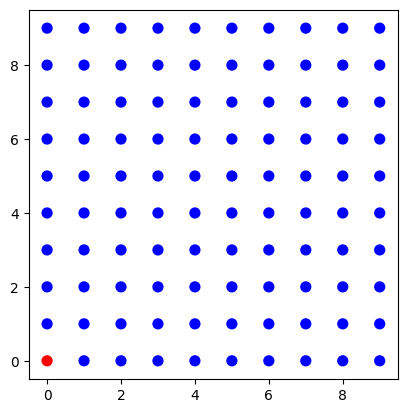

In [2]:
import matplotlib.pyplot as plt

# Define the size of the grid (n x n)
n = 10

# Specify the corner where the charging depot will be (top-left corner)
# nodes = targets + depots
# Note: If a node isn't a depot, it is a target
charging_depot_x = 0
charging_depot_y = 0

# Create a list of coordinates for all grid points
x_coords, y_coords = zip(*[(x, y) for x in range(n) for y in range(n)])

# Create a list of colors for the grid points, with a different color for the charging station
colors = ['red' if (x, y) == (charging_depot_x, charging_depot_y) else 'blue' for x, y in zip(x_coords, y_coords)]

# Create a scatter plot with dots
plt.scatter(x_coords, y_coords, c=colors, s=50)

# Set the aspect ratio to equal to make the target area square
plt.gca().set_aspect('equal', adjustable='box')

# Set axis limits to match the grid size
plt.xlim(-0.5, n - 0.5)
plt.ylim(-0.5, n - 0.5)

# Display the grid
plt.show()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i9-10900K CPU @ 3.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 1561 rows, 1533 columns and 6556 nonzeros
Model fingerprint: 0x573e2b3a
Variable types: 84 continuous, 1449 integer (1449 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 9.0000000
Presolve removed 876 rows and 249 columns
Presolve time: 0.00s
Presolved: 685 rows, 1284 columns, 3208 nonzeros
Variable types: 0 continuous, 1284 integer (1284 binary)

Root relaxation: cutoff, 41 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff  

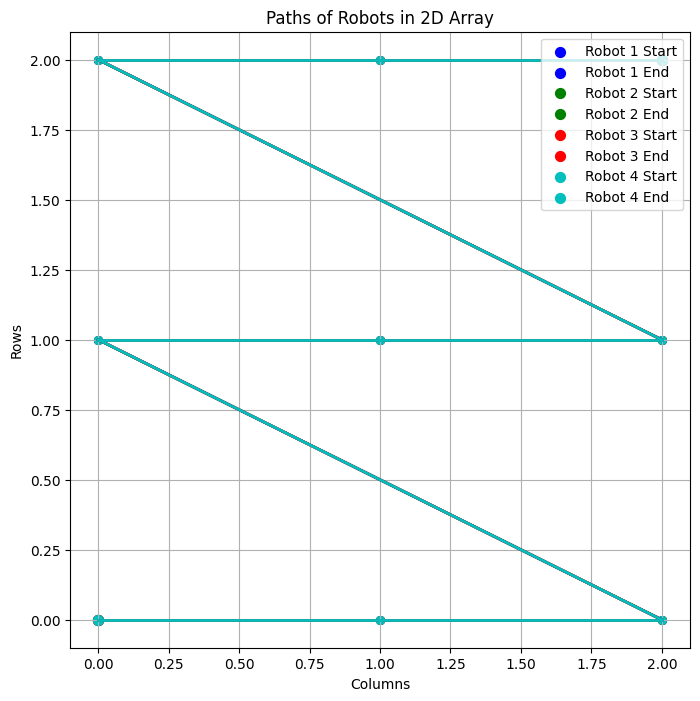

In [91]:
import random
import numpy as np
import gurobipy as gp
from gurobipy import GRB

import networkx as nx
import matplotlib.pyplot as plt

# Variables
num_rows = 3  # Number of rows
num_cols = 3  # Number of columns
K = 4   # Number of robots
T = 20  # Time
depots = 4
max_coverage_per_robot = 5
initial_fuel = [2 * num_rows * num_cols]
min_fuel_threshold = 1.0
fuel_capacity = [10.0] * K  # Fuel capacity for each robot

# Create a 2D array for targets
n = np.zeros((num_rows, num_cols), dtype=int)
# Initialize targets randomly (you can replace this with your target initialization logic)
for i in range(num_rows):
    for j in range(num_cols):
        n[i, j] = random.randint(0, 1)

fuel_consumption = [[[0.1] * T for _ in range(num_cols)] for _ in range(num_rows)]  # Max amount of fuel per robot
initial_location = [0, 2, 4, 6]  # Initial location per robot
coverage_cost = [1.0] * (num_rows * num_cols)  # Coverage cost for each target

model = gp.Model("MRPCP")   # Create Gurobi model

# Create binary variables for robot locations and target coverage
x = model.addVars(K, num_rows, num_cols, T, vtype=GRB.BINARY, name="x")
target_covered = model.addVars(K, num_rows, num_cols, T, vtype=GRB.BINARY, name="target_covered")

# Create binary variables for charging depots
charging_depot = model.addVars(num_rows, num_cols, vtype=GRB.BINARY, name="charging_depot")

# Create variables for fuel levels
fuel = model.addVars(K, T, name="fuel")
initial_fuel = model.addVars(K, name="initial_fuel")

# --------Initial conditions------------
for i in range(K):
    model.addConstr(initial_fuel[i] == 100)
    model.addConstr(x[i, initial_location[i] // num_cols, initial_location[i] % num_cols, 0] == 1)
    model.addConstr(fuel[i, 0] == initial_fuel[i])  # Fix indexing

# Define the coverage cost (minimize)
model.setObjective(gp.quicksum(coverage_cost[j] * target_covered[i, j // num_cols, j % num_cols, t]
                               for j in range(num_rows * num_cols) for i in range(K) for t in range(T)),
                   GRB.MINIMIZE)

# --------Constraints------------

# ------------- Capacity & Flow Constraints -------------------
# 1: Each target must be covered at least once
for j in range(num_rows):
    for k in range(num_cols):
        model.addConstr(gp.quicksum(target_covered[i, j, k, t] for i in range(K) for t in range(T)) >= 1)

# 2: Each robot can cover a maximum of max_coverage_per_robot targets in a single time step
for i in range(K):
    model.addConstr(gp.quicksum(target_covered[i, j, k, t] for j in range(num_rows) for k in range(num_cols) for t in range(T)) <= max_coverage_per_robot)

# 3: Ensure robots stay within their fuel constraints
for i in range(K):
    for t in range(T):
        model.addConstr(fuel[i, t] <= initial_fuel[i] + gp.quicksum(fuel_consumption[j][k][t] * x[i, j, k, t] for j in range(num_rows) for k in range(num_cols)))

# # 3.2 : Fuel level at target visited after leaving a depot
# for i in range(K):
#     for j in range(n):
#         for t in range(1, T):
#             # If robot i enters target j at time t
#             model.addConstr(fuel[i, t] == fuel_capacity[i] - gp.quicksum(fuel_consumption[i][j][t] * x[i, j, t] for j in range(n)))
#             
# : Fuel capacity constraints for each robot
# : Fuel capacity constraints for each robot
for i in range(K):
    model.addConstr(fuel_capacity[i] >= 1)
    model.addConstr(fuel_capacity[i] <= 2 * num_rows * num_cols)

# # 4: Fuel consumption when moving
# for i in range(K):
#     for j in range(n):
#         for t in range(T):
#             model.addConstr(fuel_consumption[i][j][t] * x[i, j, t] <= fuel[i, t])
# 
# # 5: Fuel capacity constraints
# for i in range(K):
#     for t in range(T):
#         model.addConstr(fuel[i, t] <= fuel_capacity[i])
# 
# 6: Robot can only cover a target it's on
for i in range(K):
    for j in range(num_rows):
        for k in range(num_cols):
            for t in range(T):
                model.addConstr(target_covered[i, j, k, t] <= x[i, j, k, t])

# 7: Robot movement constraints
# for i in range(K):
#     for j in range(num_rows):
#         for k in range(num_cols):
#             for t in range(1, T):
#                 model.addConstr(x[i, j, k, t] == x[i, j, k, t-1] + gp.quicksum(x[k, j, k, t-1] for k in range(K) if k != i))

# 8: Ensure that robots can only move if they have enough fuel
for i in range(K):
    for j in range(num_rows):
        for k in range(num_cols):
            for t in range(1, T):
                model.addConstr(fuel[i, t] >= min_fuel_threshold * x[i, j, k, t-1] - (1 - x[i, j, k, t]))

# Set the robot starting and ending positions, and enforce visiting and leaving each target
for i in range(K):
    model.addConstr(x[i, initial_location[i] // num_cols, initial_location[i] % num_cols, 0] == 1)
    model.addConstr(x[i, initial_location[i] // num_cols, initial_location[i] % num_cols, T - 1] == 1)

    # Every robot visits and leaves each target
    for j in range(num_rows):
        for k in range(num_cols):
            model.addConstr(gp.quicksum(x[i, j, k, t] for t in range(T)) == 2)


# Optimize the model
model.optimize()

if model.status == GRB.OPTIMAL:
    print("Optimal solution found. Total cost:", model.ObjVal)

    # Extract the variables and values
    x_values = model.getAttr("X", x)
    target_covered_values = model.getAttr("X", target_covered)
    charging_depot_values = model.getAttr("X", charging_depot)

    # Extract robot paths
    robot_paths = [[] for _ in range(K)]
    for i in range(K):
        for j in range(num_rows):
            for k in range(num_cols):
                for t in range(T):
                    if x_values[i, j, k, t] > 0.5:
                        robot_paths[i].append((j, k, t))  # Store (row, col, time) tuples

    # Plot the paths of the robots in the 2D array
    plt.figure(figsize=(8, 8))
    
    # Define colors for each robot
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    for i in range(K):
        path = robot_paths[i]
        color = colors[i % len(colors)]  # Cycle through colors if more than 7 robots
    
        # Plot the start point
        start_row, start_col, _ = path[0]
        plt.scatter(start_col, start_row, color=color, s=50, label=f'Robot {i + 1} Start')
    
        for m in range(len(path) - 1):
            current_row, current_col, current_time = path[m]
            next_row, next_col, next_time = path[m + 1]
    
            # Plot the current node
            plt.scatter(current_col, current_row, color=color, s=30)
    
            plt.plot([current_col, next_col], [current_row, next_row], color=color, linestyle='-', linewidth=2)
    
        # Plot the end point
        end_row, end_col, _ = path[-1]
        plt.scatter(end_col, end_row, color=color, s=50, label=f'Robot {i + 1} End')
    
    plt.title('Paths of Robots in 2D Array')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.legend()
    plt.grid(True)
    plt.show()


else:
    print("No solution found. Status code:", model.status)

model.dispose();   